In [1]:
import sys
sys.path.append('../AGDS/')
%load_ext autoreload
%autoreload 2

## AGDS Implementation


## Associative transformation

First we need to create a proper represenation of the input data as the associative graph. In my case as an input I will use pandas `DataFrame` as input and `pygrahphviz` graph to create the graph. As an example I will use data set from the lectures.

In [2]:
import pandas as pd
from AGDS.AssociativeGraph import AssociativeGraph

data = {'id': ['O1', 'O2', 'O3', 'O4', 'O5', 'O6', 'O7', 'O8', 'O9'],
        'Sepal length': [5.4, 6.3, 6.0, 6.7, 6.0, 5.9, 6.0, 6.7, 6.5],
        'Sepal width': [3.0, 3.3, 2.7, 3.0, 2.2, 3.2, 3.0, 2.5, 3.2],
        'Petal length': [4.5, 4.7, 5.1, 5.0, 5.0, 4.8, 4.8, 5.0, 5.1],
        'Petal width': [1.5, 1.6, 1.6, 1.7, 1.5, 1.8, 1.8, 2.0, 2.0],
        'Class': ['Versicolor', 'Versicolor', 'Versicolor', 'Versicolor', "Viriginica", 'Versicolor', "Viriginica", "Viriginica", "Viriginica"]}
input_table = pd.DataFrame(data)

In [3]:
input_table.head()

,id,Sepal length,Sepal width,Petal length,Petal width,Class
0,O1,5.4,3.0,4.5,1.5,Versicolor
1,O2,6.3,3.3,4.7,1.6,Versicolor
2,O3,6.0,2.7,5.1,1.6,Versicolor
3,O4,6.7,3.0,5.0,1.7,Versicolor
4,O5,6.0,2.2,5.0,1.5,Viriginica


Later in the script I will use object of my own class `AssociativeGraph` which is transforming the dataframe into proper graph on its construction. For now I will present construction process.

In [4]:
graph = AssociativeGraph(input_table)

In [5]:
column_names = [x for x in input_table.columns if x != "id"]
print(column_names)

['Sepal length', 'Sepal width', 'Petal length', 'Petal width', 'Class']


First we need to add attributes names and connect them with `param` node.

/usr/local/anaconda3/envs/CI/lib/python3.7/site-packages/pygraphviz/agraph.py:1390: RuntimeWarning: Warning: flat edge between adjacent nodes one of which has a record shape - replace records with HTML-like labels
  Edge 3469282498869697720 -- -7708563425868363958
Error: lost -7708563425868363958 3469282498869697720 edge

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


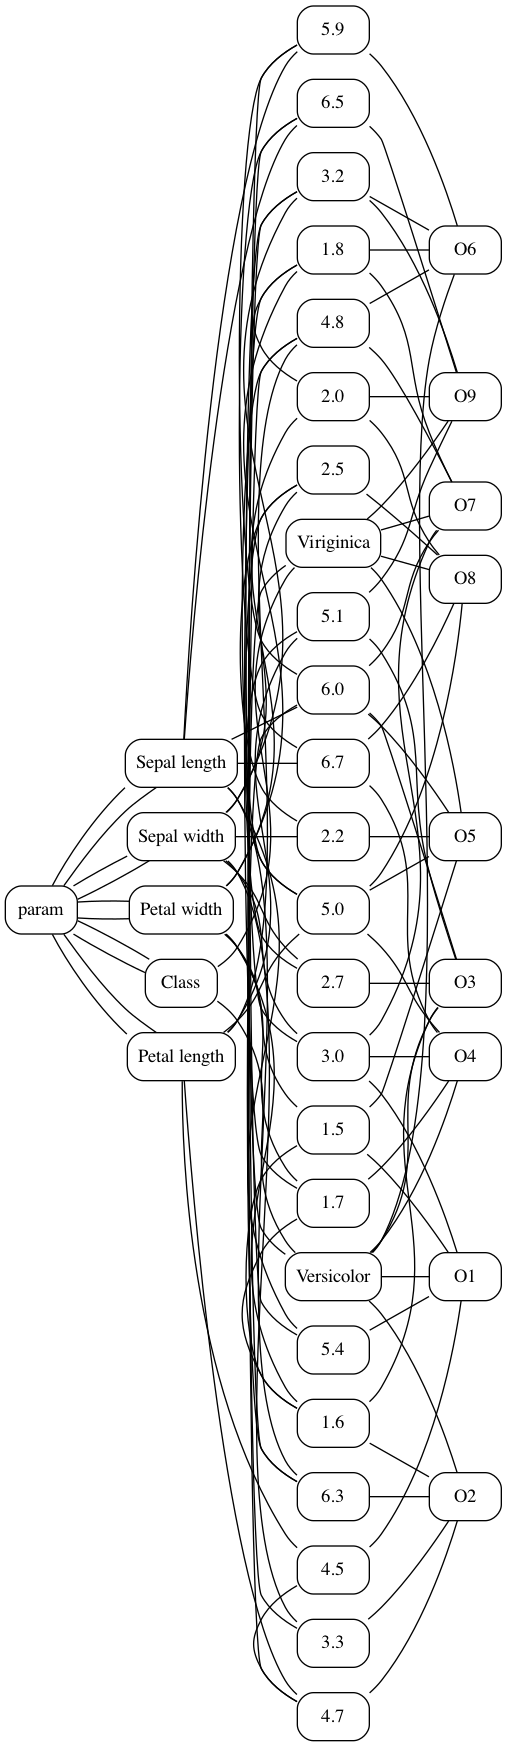

In [6]:
graph.add_node("param")
for column in column_names:
    graph.add_node(column)
    graph.add_edge( "param", column)

graph.render_graph()

Now we need to add all the attributes of every entry into our graph and connect it with its column name and prev and next items. 

As we can have multiple instances of different attributes but with the same value I will create the node `id` by hash(`$attribute_name:$attribute_value`) (e.g `hash("Sepal length:2.2")`). 

In [7]:
def get_hash(attribute_name, attribute_value):
    return hash("{attribute_name}_{attribute_value}".format(attribute_value=attribute_value, attribute_name=attribute_name))

In [8]:
from itertools import islice

def previous_current_next(iterable):
    """
    Make an iterator that yields an (previous, current, next) tuple per element.
    """
    iterable = iter(iterable)
    prv = None
    cur = iterable.__next__()
    try:
        while True:
            nxt = iterable.__next__()
            yield (prv, cur, nxt)
            prv = cur
            cur = nxt
    except StopIteration:
        yield (prv, cur, None)

for column_name in column_names:
    column = list(input_table[column_name])
    column.sort()
    for prev_item, attribute, next_item in previous_current_next(column):
        prev_id = get_hash(column_name, prev_item)
        node_id = get_hash(column_name, attribute)
        next_id = get_hash(column_name, next_item)

        graph.add_node(node_id, label=attribute)
        if not graph.has_edge(column_name, node_id):
            graph.add_edge(column_name, node_id)
        if prev_item and not graph.has_edge(prev_id, node_id) and prev_item != attribute:
            graph.add_edge(prev_id, node_id, constraint=False)
        if next_item and not graph.has_edge(node_id, next_id) and next_item != attribute:
            graph.add_edge(node_id, next_id, constraint=False)

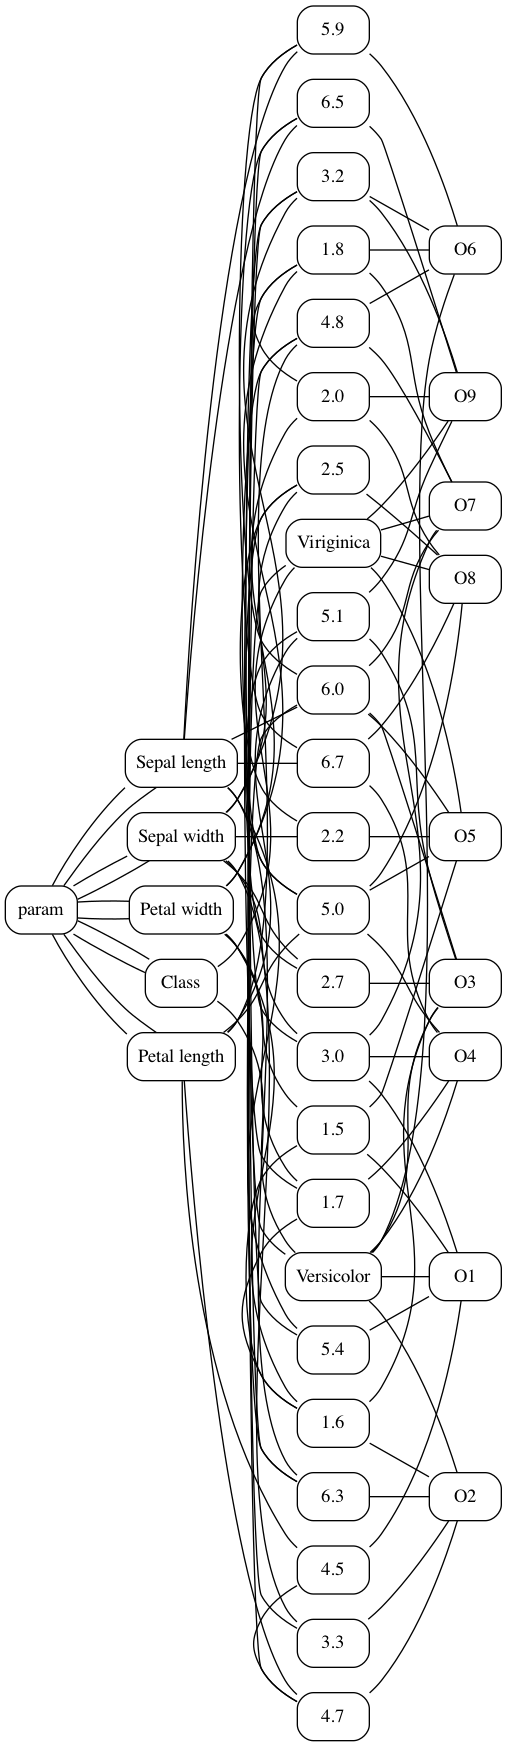

In [9]:
graph.render_graph()

Now let's connect entity id node with its attributes.

In [10]:
rows = input_table.to_dict(orient='records')


In [11]:
for row in rows:
    entity_id = row["id"]
    graph.add_node(entity_id)
    for column_name, attribute in row.items():
        if column_name != "id":
            node_id = get_hash(column_name, attribute)
            graph.add_edge(node_id, entity_id)

/usr/local/anaconda3/envs/CI/lib/python3.7/site-packages/pygraphviz/agraph.py:1390: RuntimeWarning: Warning: flat edge between adjacent nodes one of which has a record shape - replace records with HTML-like labels
  Edge -5793370153197970197 -- -7996718279977715556
Error: lost -5793370153197970197 -7996718279977715556 edge

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


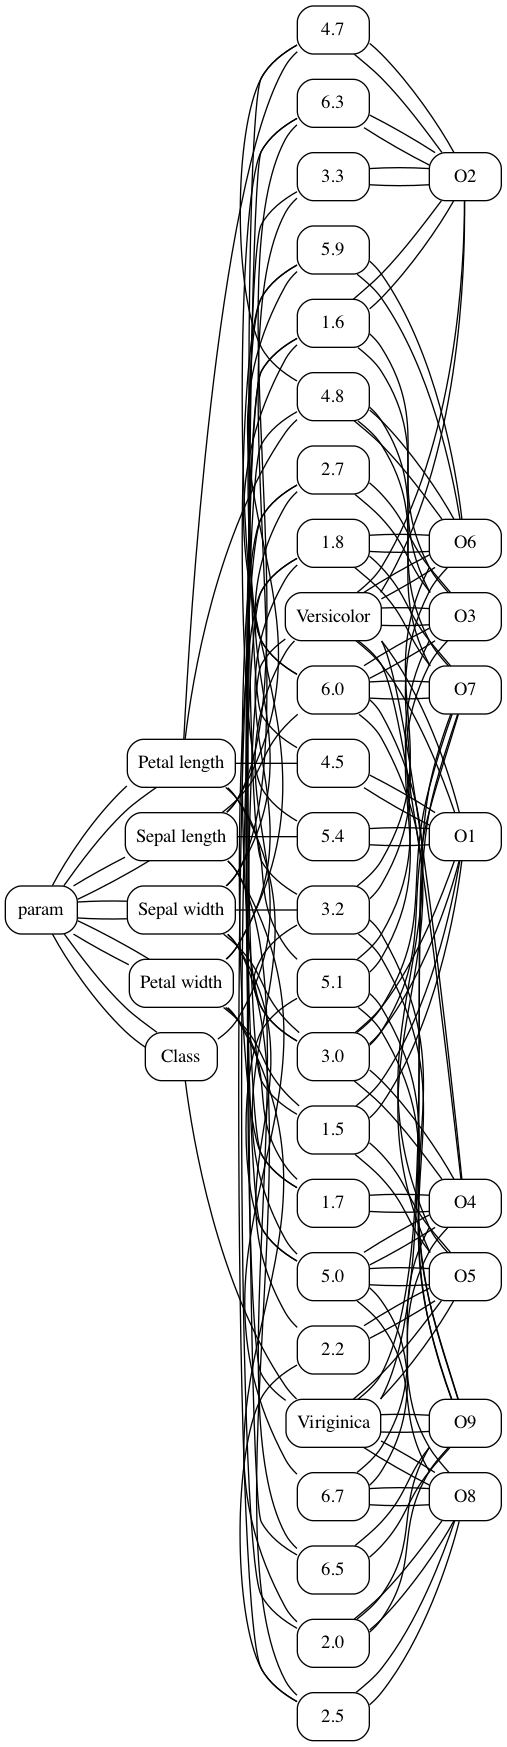

In [12]:
graph.render_graph()

In [13]:
graph2 = AssociativeGraph(input_table)

In [14]:
graph2.neighbors("O1")

['-6303179644639032947',
 '3469282498869697720',
 '-6294153636572629614',
 '8313081832127008083',
 '-558049864989092321']

In [15]:
print(graph2.inference("O1"))

node O1 neighbors ['-6303179644639032947', '3469282498869697720', '-6294153636572629614', '8313081832127008083', '-558049864989092321']
node -6303179644639032947 neighbors ['3715690597895682857', 'Sepal length']
node 3469282498869697720 neighbors ['6003551311410943534', 'O4', 'O7', 'Sepal width', '-7708563425868363958']
node -6294153636572629614 neighbors ['-2768149852611140121', 'Petal length']
node 8313081832127008083 neighbors ['5460195899176367496', 'O5', 'Petal width']
node -558049864989092321 neighbors ['-2284776566287648299', 'O2', 'O3', 'O6', 'Class']
node 3715690597895682857 neighbors ['-2709842833973792541']
node Sepal length neighbors ['-3675926855234801254', '-5793370153197970197', '-7996718279977715556', 'param']
node 6003551311410943534 neighbors ['6659503051428320047', 'O9']
node O4 neighbors ['8874574168009584840', '-8847782203418228142']
node O7 neighbors ['-4191225914030555476', '2434768911119480680']
node Sepal width neighbors ['-2961847668802041703', '-1597959969194

{'O1': 1,
 '-6303179644639032947': 1,
 '3469282498869697720': 1,
 '-6294153636572629614': 1,
 '8313081832127008083': 1,
 '-558049864989092321': 1,
 '3715690597895682857': 1,
 'Sepal length': 1,
 '6003551311410943534': 1,
 'O4': 1,
 'O7': 1,
 'Sepal width': 1,
 '-7708563425868363958': 1,
 '-2768149852611140121': 1,
 'Petal length': 1,
 '5460195899176367496': 1,
 'O5': 1,
 'Petal width': 1,
 '-2284776566287648299': 1,
 'O2': 1,
 'O3': 1,
 'O6': 1,
 'Class': 1,
 '-2709842833973792541': 1,
 '-3675926855234801254': 1,
 '-5793370153197970197': 1,
 '-7996718279977715556': 1,
 'param': 1,
 '6659503051428320047': 1,
 'O9': 1,
 '8874574168009584840': 1,
 '-8847782203418228142': 1,
 '-4191225914030555476': 1,
 '2434768911119480680': 1,
 '-2961847668802041703': 1,
 '-1597959969194987373': 1,
 '7075985098295944833': 1,
 '9079495237783966622': 1,
 'O8': 1}